In [1]:
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    print("Fetching month chart...")
    month_chart = pd.read_sql("""
        select month_chart.*, stock.name, stock.exchange from month_chart
        join stock on month_chart.code = stock.code;
    """, maria_home())
    print("Building layer1...")

    begin = YearMonth(2002, 4)
    end = YearMonth(2023, 3)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
        df1 = df1[df1["val_last"] >= 1000_0000]
        df2.loc[df2["val_last"] == 0, "close"] = 0

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
            "거래대금": df1["val"],
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = layer1["확정실적"].apply(str)
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,거래대금,...,E_QoQ,R/A_QoQ,GP/A_QoQ,O/A_QoQ,E/A_QoQ,R/EQ_QoQ,GP/EQ_QoQ,O/EQ_QoQ,E/EQ_QoQ,확정실적
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,2604,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,11302,706504,15311799550,...,2.151386,0.039735,0.013609,0.007998,0.012766,0.081359,0.027205,0.015848,0.025052,2001-4Q
2,054620,APS홀딩스,코스닥,2002-04,2002-05,20934600000,2002-04-30,6162,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,-0.608231,-0.011676,-0.001393,0.003334,-0.017559,-0.014840,-0.001662,0.004425,-0.023219,2001-4Q
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,28006,4513180,263372467300,...,1.157134,0.248107,0.137269,0.058049,0.032612,0.635466,0.395791,0.181644,0.106711,2001-4Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387685,000540,흥국화재,유가증권,2023-02,2023-03,239946279075,2023-02-28,3735,1800328,6600268565,...,NaN,0.005376,NaN,0.001088,NaN,0.380950,NaN,0.033848,NaN,2022-3Q
387686,000547,흥국화재2우B,유가증권,2023-02,2023-03,3070464000,2023-02-28,19990,105811,2268502740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
387687,003280,흥아해운,유가증권,2023-02,2023-03,352222477035,2023-02-28,1465,7927404,12011059811,...,8.103269,0.085515,0.043808,0.042733,0.018525,0.229167,0.108547,0.102940,0.046502,2022-3Q
387688,037440,희림,코스닥,2023-02,2023-03,138807075750,2023-02-28,9970,17197648,176303839820,...,2.517199,-0.004923,0.011450,0.005833,0.010255,-0.045885,0.030324,0.016097,0.028984,2022-3Q


In [7]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출액": "R",
        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = [
    "R_QoQ",
    "GP_QoQ",
    "O_QoQ",
    "E_QoQ",

    "R/A_QoQ",
    "GP/A_QoQ",
    "O/A_QoQ",
    "E/A_QoQ",

    "R/EQ_QoQ",
    "GP/EQ_QoQ",
    "O/EQ_QoQ",
    "E/EQ_QoQ",

    "BIS",
    "BIS_QoQ",
]

for pos in ["R", "GP", "O", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["A", "EQ"]:
    for pos in ["R", "GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

layer2["TV/P"] = layer2["TV"] / layer2["P"]
factors.append("TV/P")

result = pd.DataFrame()
yms = layer2["매수년월"].unique()

from core.strategy import recipe

recipes = [
    {
        "P": -4,
        "GP/P": 4,
        "EQ/P": 2,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
    },
    {
        "P": -4,
        "R/P": 4,
        "EQ/P": 2,
        "R_QoQ": 1,
        "O_QoQ": 1,
        "R/A_QoQ": 1,
        "O/A_QoQ": 1,
    },
    {
        "P": -4,
        "R/P": 4,
        "EQ/P": 2,
        "R/A_QoQ": 1,
        "O/A_QoQ": 1,
    },
    {
        "P": -4,
        "R/P": 4,
        "EQ/P": 2,
        "R/A_QoQ": 2,
        "O/A_QoQ": 2,
    }
]

print(pd.DataFrame(recipes))

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_pct = f"{factor}_pct"
        df[colname_pct] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for i in range(len(recipes)):
        factor = f"super{i}"
        recipe = recipes[i]
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else (1 - df[f"{k}_pct"]) * abs(w) for k, w in recipe.items()])
        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[factor] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = [f"super{i}" for i in range(len(recipes))] + factors
result

   P  GP/P  EQ/P  GP_QoQ  O_QoQ  GP/A_QoQ  O/A_QoQ  R/P  R_QoQ  R/A_QoQ
0 -4   4.0     2     1.0    1.0       1.0        1  NaN    NaN      NaN
1 -4   NaN     2     NaN    1.0       NaN        1  4.0    1.0      1.0
2 -4   NaN     2     NaN    NaN       NaN        1  4.0    NaN      1.0
3 -4   NaN     2     NaN    NaN       NaN        2  4.0    NaN      2.0
2023-02

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,TV,...,P_pct,TV/P_pct,super0,super0_pct,super1,super1_pct,super2,super2_pct,super3,super3_pct
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,2604,1480725,12071273140,...,19.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,11302,706504,15311799550,...,79.0,18.0,20.428571,45.0,22.928571,50.0,15.666667,45.0,23.571429,50.0
2,054620,APS홀딩스,코스닥,2002-04,2002-05,20934600000,2002-04-30,6162,3623832,41050604910,...,34.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,53.0,18.0,43.285714,87.0,38.571429,82.0,32.500000,76.0,34.428571,75.0
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,28006,4513180,263372467300,...,97.0,29.0,30.928571,67.0,25.500000,55.0,14.583333,42.0,26.428571,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387685,000540,흥국화재,유가증권,2023-02,2023-03,239946279075,2023-02-28,3735,1800328,6600268565,...,68.0,12.0,NaN,NaN,37.928571,83.0,35.166667,84.0,37.857143,82.0
387686,000547,흥국화재2우B,유가증권,2023-02,2023-03,3070464000,2023-02-28,19990,105811,2268502740,...,1.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387687,003280,흥아해운,유가증권,2023-02,2023-03,352222477035,2023-02-28,1465,7927404,12011059811,...,78.0,16.0,14.500000,32.0,14.857143,35.0,1.333333,22.0,14.857143,35.0
387688,037440,희림,코스닥,2023-02,2023-03,138807075750,2023-02-28,9970,17197648,176303839820,...,51.0,92.0,23.500000,53.0,23.571429,53.0,17.583333,50.0,23.000000,51.0


In [8]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

plt.ioff()

# plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

target_factors = factors
# target_factors = [f for f in factors if f.startswith("super")]
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    print(f"\r{i + 1}/{len(target_factors)}", end="")
    factor = factors[i]
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    corr = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_pct]["cagr"],
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "h5-t5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(5).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h5-t5+mdd5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(5).mean() + mdd_by_pct_desc.head(
                5).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(db_file), if_exists="replace")
summary["strength"] = pow(summary["spearman"] * summary["h10"], 2)
summary = summary.sort_values("strength", ascending=False)
summary

32/32
2002-04 2023-03
   P  GP/P  EQ/P  GP_QoQ  O_QoQ  GP/A_QoQ  O/A_QoQ  R/P  R_QoQ  R/A_QoQ
0 -4   4.0     2     1.0    1.0       1.0        1  NaN    NaN      NaN
1 -4   NaN     2     NaN    1.0       NaN        1  4.0    1.0      1.0
2 -4   NaN     2     NaN    NaN       NaN        1  4.0    NaN      1.0
3 -4   NaN     2     NaN    NaN       NaN        2  4.0    NaN      2.0


,spearman,h5,h10,t5,t10,h5-t5,h10-t10,mdd5,h5-t5+mdd5,h10-t10+mdd10,mean,median,strength
factor,,,,,,,,,,,,,
super0,0.940702,0.409709,0.371161,-0.132556,-0.102894,0.542265,0.474054,-0.529183,0.013082,-0.047110,0.102282,0.092390,0.121907
super3,0.937558,0.412118,0.348962,-0.095958,-0.075235,0.508076,0.424197,-0.487065,0.021011,-0.080569,0.091514,0.066503,0.107042
super1,0.937762,0.417218,0.344444,-0.106017,-0.078384,0.523235,0.422828,-0.479640,0.043595,-0.076419,0.091264,0.056106,0.104333
super2,0.935902,0.390505,0.335081,-0.075394,-0.069966,0.465898,0.405047,-0.496983,-0.031085,-0.111982,0.090271,0.065843,0.098347
EQ/P,0.916976,0.194376,0.196113,-0.132379,-0.083481,0.326755,0.279594,-0.552464,-0.225709,-0.277784,0.081483,0.087814,0.032339
GP/P,0.888989,0.202588,0.196390,-0.093101,-0.085502,0.295689,0.281893,-0.589008,-0.293318,-0.283044,0.094432,0.105734,0.030481
R/P,0.878032,0.188115,0.175861,-0.101351,-0.065649,0.289466,0.241511,-0.568612,-0.279145,-0.298232,0.083253,0.095925,0.023843
O_QoQ,0.833747,0.193548,0.183593,-0.007349,-0.009178,0.200897,0.192771,-0.626440,-0.425543,-0.403184,0.081071,0.083113,0.023430
O/P,0.801272,0.175525,0.182637,-0.007043,0.004408,0.182568,0.178229,-0.598928,-0.416360,-0.421304,0.097864,0.096658,0.021416


In [4]:
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super1"
print(recipes[1])

head = 20
result2 = result.copy()
result2 = result[~result["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
# result2 = result2[result2["E/EQ_pct"] > 5]

result2 = result2[result2["TV/P_pct"] > 5]
result2 = result2[result2["TV/P_pct"] < 85]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result2.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", factor]]

{'P': -4, 'R/P': 4, 'EQ/P': 2, 'R_QoQ': 1, 'O_QoQ': 1, 'R/A_QoQ': 1, 'O/A_QoQ': 1}
          CAGR                                        MDD      Mean
전략    0.509113    (-0.42462539846436, (2008-05, 2008-10))  0.038479
벤치마크  0.084715  (-0.5734097674713801, (2007-07, 2008-10))  0.009126


code    종목명       수익률   거래소         매수일         매도일  \
매수년월    매도년월                                                                    
2002-04 2002-05 487     005390   신성통상  0.128617  유가증권  2002-04-30  2002-05-31   
                378     006090   사조오양 -0.024421  유가증권  2002-04-30  2002-05-31   
                247     001070   대한방직  0.014981  유가증권  2002-04-30  2002-05-31   
                717     025880  케이씨피드  0.038889   코스닥  2002-04-30  2002-05-31   
                157     001140     국보  0.057447  유가증권  2002-04-30  2002-05-31   
...                        ...    ...       ...   ...         ...         ...   
2023-02 2023-03 385803  092780  동양피스톤 -0.011742  유가증권  2023-02-28  2023-03-10   
                386697  012280   영화금속  0.001103  유가증권  2023-02-28  2023-03-10   
                387091  065060    지엔코 -0.072539   코스닥  2023-02-28  2023-03-10   
                385749  021040  대호특수강  0.095413   코스닥  2023-02-28  2023-03-10   
                386330  115570  스타플렉스  0.014572   코스닥  2023-02-28  2023-03-10   

                         매수가     매도가     super1  
매수년월    매도년월                                     
2002-04 2002-05 487      311   351.0  61.500000  
                378     2416  2357.0  60.500000  
                247     2670  2710.0  59.571429  
                717      720   748.0  58.714286  
                157      470   497.0  58.071429  
...                      ...     ...        ...  
2023-02 2023-03 385803  5110  5050.0  55.142857  
                386697   907   908.0  55.000000  
                387091   386   358.0  54.928571  
                385749  5450  5970.0  54.928571  
                386330  5490  5570.0  54.785714  

[5020 rows x 9 columns]

In [5]:
revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2002-04,2002-05,-0.048103,0.245289,0.29,0.951897,1.245289
2002-05,2002-06,-0.108541,-0.061595,0.05,0.848577,1.168585
2002-06,2002-07,-0.009098,0.055403,0.06,0.840857,1.233328
2002-07,2002-08,0.033955,0.100470,0.07,0.869409,1.357240
2002-08,2002-09,-0.158367,-0.015850,0.14,0.731723,1.335727
...,...,...,...,...,...,...
2022-10,2022-11,0.077130,0.132269,0.06,5.325707,5022.967810
2022-11,2022-12,-0.057257,-0.051761,0.01,5.020772,4762.972828
2022-12,2023-01,0.091139,0.106145,0.02,5.478358,5268.540674


전체 개월 수      251.00
초과수익 개월 수    178.00
아웃퍼폼 총합        9.03
언더퍼폼 총합       -1.68
dtype: float64

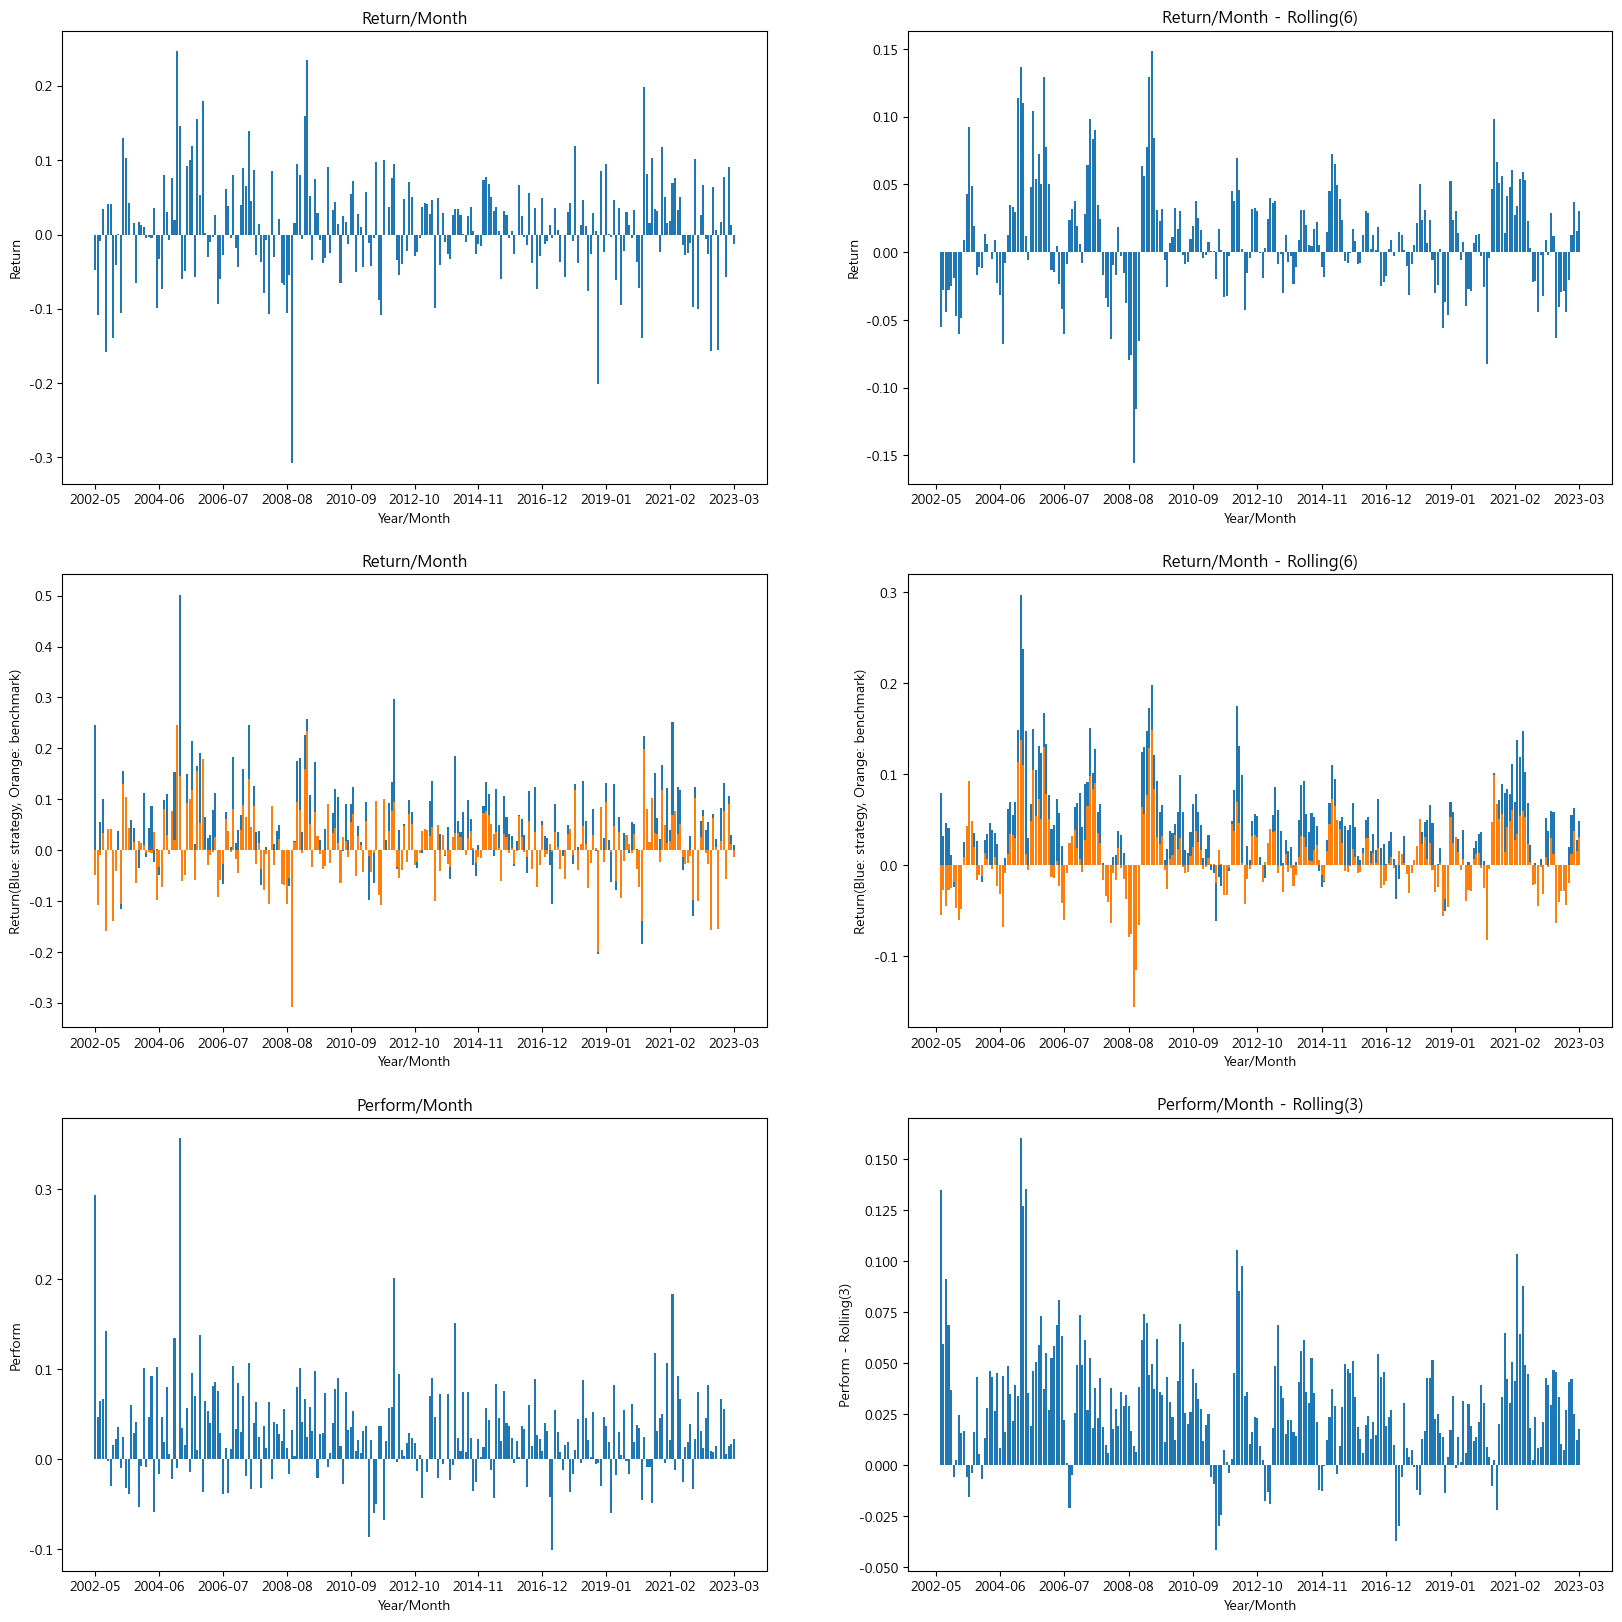

In [6]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"Return/Month")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["전략 수익률"])

window = 3
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"].rolling(window).mean())

ax3.set_title(f"Return/Month")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(months, revisions["전략 수익률"])
ax3.bar(months, revisions["벤치마크 수익률"])

ax4.set_title("Return/Month - Rolling(6)")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(months, revisions["전략 수익률"].rolling(window).mean())
ax4.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax5.set_title("Perform/Month")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax6.set_title(f"Perform/Month - Rolling({window})")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({window})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(months, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})